<a href="https://colab.research.google.com/github/CalculatedContent/xgboost2ww/blob/main/notebooks/XGBWW_Catalog_Random100_XGBoost_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# XGBWW catalog-driven random-per-source XGBoost benchmark

This notebook:
1. Loads the catalog DataFrame produced by `XGBWW_Dataset_Catalog_Checkpoint.ipynb`.
2. Randomly samples **100 datasets per source** (classification only).
3. Trains one XGBoost model per sampled dataset with a small CV-based round selection.
4. Converts each trained XGBoost model with **xgboost2ww** and runs `WeightWatcher.analyze(ERG=True, randomize=True)`.
5. Records train/test accuracies plus WeightWatcher metrics (`alpha`, `ERG_gap`, `num_traps`) and plots accuracy vs each metric.


## 1) Mount Google Drive and configure paths


In [1]:
from google.colab import drive
from pathlib import Path
import json

# ===== USER CONFIG =====
CATALOG_CSV = Path("/content/drive/MyDrive/xgbwwdata/catalog_checkpoint/dataset_catalog.csv")
RANDOM_SEED = 42
RANDOM_SAMPLE_SIZE = 100
TEST_SIZE = 0.20
EXPERIMENT_ROOT = Path("/content/drive/MyDrive/xgbwwdata/experiment_checkpoints")
DEFAULT_EXPERIMENT_BASENAME = "random100_xgboost_accuracy"

# Restart control
RESTART_EXPERIMENT = True
EXPERIMENT_NAME = "random100_xgboost_accuracy_run03" # Required for restart.
AUTO_INCREMENT_IF_NAME_MISSING = True
# =======================


def next_experiment_name(root: Path, base_name: str) -> str:
    existing = [d.name for d in root.glob(f"{base_name}_run*") if d.is_dir()]
    nums = []
    for name in existing:
        suffix = name.replace(f"{base_name}_run", "")
        if suffix.isdigit():
            nums.append(int(suffix))
    n = (max(nums) + 1) if nums else 1
    return f"{base_name}_run{n:02d}"


drive.mount("/content/drive")
EXPERIMENT_ROOT.mkdir(parents=True, exist_ok=True)

if RESTART_EXPERIMENT:
    if not EXPERIMENT_NAME:
        raise ValueError("Set EXPERIMENT_NAME when RESTART_EXPERIMENT=True.")
    EXPERIMENT_ID = EXPERIMENT_NAME
else:
    if EXPERIMENT_NAME:
        EXPERIMENT_ID = EXPERIMENT_NAME
    elif AUTO_INCREMENT_IF_NAME_MISSING:
        EXPERIMENT_ID = next_experiment_name(EXPERIMENT_ROOT, DEFAULT_EXPERIMENT_BASENAME)
    else:
        EXPERIMENT_ID = DEFAULT_EXPERIMENT_BASENAME

CHECKPOINT_DIR = EXPERIMENT_ROOT / EXPERIMENT_ID
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINT_RESULTS_CSV = CHECKPOINT_DIR / "checkpoint_results.csv"
CHECKPOINT_ERRORS_CSV = CHECKPOINT_DIR / "errors.csv"
SELECTED_DATASETS_CSV = CHECKPOINT_DIR / "selected_datasets.csv"
EXPERIMENT_CONFIG_JSON = CHECKPOINT_DIR / "experiment_config.json"

print("Catalog path:", CATALOG_CSV)
print("Experiment checkpoint:", CHECKPOINT_DIR)
print("Restart mode:", RESTART_EXPERIMENT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Catalog path: /content/drive/MyDrive/xgbwwdata/catalog_checkpoint/dataset_catalog.csv
Experiment checkpoint: /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_run03
Restart mode: True


In [2]:
!cat /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_run03/checkpoint_results.csv

source,source_dataset_id,dataset_uid,unique_id,name,task_type,experiment_type,n_rows,n_features,n_classes,scan_timestamp_utc,status,error_message,xgboost_params,rounds,train_size,test_size_rows,train_accuracy,test_accuracy,alpha,ERG_gap,num_traps,dataset_name,dataset_openml_id,test_size
openml,75,openml:75,openml|75,"BNG(autos,nominal,1000000)",classification,multiclass_classification,,,,2026-02-25T03:40:57.001397+00:00,failed,tuple index out of range,,,,,,,,,,"BNG(autos,nominal,1000000)",,0.2
openml,115,openml:115,openml|115,"BNG(mfeat-karhunen,nominal,1000000)",classification,multiclass_classification,,,,2026-02-25T03:41:28.907993+00:00,pending,,,,,,,,,,,"BNG(mfeat-karhunen,nominal,1000000)",,0.2
openml,1487,openml:1487,openml|1487,ozone-level-8hr,classification,binary_classification,,,,2026-02-25T17:26:50.131719+00:00,pending,,,,,,,,,,,ozone-level-8hr,,0.2
openml,845,openml:845,openml|845,fri_c0_1000_10,classification,binary_classification,,,,2026-02-25T16:23:12.648483+00:00,pending

## 2) Install dependencies

Use the same repository-install flow as the other Colab notebooks (no `pip install xgbwwdata`).


In [3]:
# Install xgbwwdata from a fresh clone using the repository installer script
!rm -rf /content/repo_xgbwwdata
!git clone https://github.com/CalculatedContent/xgbwwdata.git /content/repo_xgbwwdata
%run /content/repo_xgbwwdata/scripts/colab_install.py --repo /content/repo_xgbwwdata

# Notebook-specific dependencies
%pip install -q openml pmlb keel-ds xgboost scikit-learn xgboost2ww weightwatcher


Cloning into '/content/repo_xgbwwdata'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 142 (delta 11), reused 0 (delta 0), pack-reused 100 (from 2)
Receiving objects: 100% (142/142), 233.90 KiB | 1.59 MiB/s, done.
Resolving deltas: 100% (48/48), done.
+ /usr/bin/python3 -m pip install -U pip setuptools wheel
+ /usr/bin/python3 -m pip install -r /content/repo_xgbwwdata/requirements.txt
+ /usr/bin/python3 -m pip install -e /content/repo_xgbwwdata --no-build-isolation --no-deps
module: <module 'xgbwwdata' from '/content/repo_xgbwwdata/src/xgbwwdata/__init__.py'>
__file__: /content/repo_xgbwwdata/src/xgbwwdata/__init__.py
__path__: ['/content/repo_xgbwwdata/src/xgbwwdata']
exports: ['Filters', 'ScanOptions', 'config', 'enable_logging', 'load_dataset', 'logging', 'registry', 'scan_datasets', 'sources']
import OK


## 3) Imports


In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xgboost as xgb
import weightwatcher as ww

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgbwwdata import Filters, load_dataset
from xgboost2ww import convert


## 4) Load catalog and pick 100 random dataset UIDs (checkpoint-aware)


In [5]:
if not CATALOG_CSV.exists():
    raise FileNotFoundError(f"Catalog not found: {CATALOG_CSV}. Run XGBWW_Dataset_Catalog_Checkpoint.ipynb first.")

df_catalog = pd.read_csv(CATALOG_CSV)
print("Catalog shape:", df_catalog.shape)

required_cols = {"dataset_uid", "source", "task_type"}
missing = required_cols - set(df_catalog.columns)
if missing:
    raise ValueError(f"Catalog is missing required columns: {missing}")

# Accuracy is for classification; keep classification-like tasks
df_cls = df_catalog[df_catalog["task_type"].astype(str).str.contains("classification", case=False, na=False)].copy()
if df_cls.empty:
    raise ValueError("No classification datasets found in catalog.")

# Select 100 random dataset UIDs up front for this experiment.
n_select = min(RANDOM_SAMPLE_SIZE, len(df_cls))
df_pick = df_cls.sample(n=n_select, random_state=RANDOM_SEED).reset_index(drop=True)

print("Selected datasets:", len(df_pick))
display(df_pick[["source", "dataset_uid", "name", "task_type"]].sort_values(["source", "dataset_uid"]))

# Initialize or reload checkpoint table
if RESTART_EXPERIMENT and CHECKPOINT_RESULTS_CSV.exists():
    checkpoint_df = pd.read_csv(CHECKPOINT_RESULTS_CSV)
    print(f"Loaded existing checkpoint rows: {len(checkpoint_df)}")
else:
    checkpoint_df = df_pick.copy()
    checkpoint_df["status"] = "pending"
    checkpoint_df["error_message"] = ""

    # model / hyperparameter fields (blank at initialization)
    checkpoint_df["xgboost_params"] = ""
    checkpoint_df["rounds"] = np.nan
    checkpoint_df["n_classes"] = np.nan
    checkpoint_df["train_size"] = np.nan
    checkpoint_df["test_size_rows"] = np.nan

    # train/test accuracy fields
    checkpoint_df["train_accuracy"] = np.nan
    checkpoint_df["test_accuracy"] = np.nan

    # weightwatcher metrics
    checkpoint_df["alpha"] = np.nan
    checkpoint_df["ERG_gap"] = np.nan
    checkpoint_df["num_traps"] = np.nan

    # metadata from actual loaded data
    checkpoint_df["dataset_name"] = checkpoint_df.get("name", "")
    checkpoint_df["dataset_openml_id"] = checkpoint_df.get("openml_data_id", np.nan)
    checkpoint_df["n_rows"] = np.nan
    checkpoint_df["n_features"] = np.nan
    checkpoint_df["test_size"] = TEST_SIZE

# Ensure the selected datasets are saved for restart reproducibility
if not SELECTED_DATASETS_CSV.exists():
    df_pick.to_csv(SELECTED_DATASETS_CSV, index=False)

# If restarting, trust existing selected datasets file when present
if RESTART_EXPERIMENT and SELECTED_DATASETS_CSV.exists():
    df_pick = pd.read_csv(SELECTED_DATASETS_CSV)

# Save initial checkpoint immediately
checkpoint_df.to_csv(CHECKPOINT_RESULTS_CSV, index=False)
print("Checkpoint file:", CHECKPOINT_RESULTS_CSV)


Catalog shape: (1376, 11)
Selected datasets: 100


,source,dataset_uid,name,task_type
95,keel,keel:banana,banana,classification
59,keel,keel:bupa,bupa,classification
97,openml,openml:1011,ecoli,classification
62,openml,openml:1022,mfeat-pixel,classification
50,openml,openml:1024,cjs,classification
...,...,...,...,...
80,openml,openml:986,analcatdata_marketing,classification
44,openml,openml:990,eucalyptus,classification
99,pmlb,pmlb:GAMETES_Epistasis_2_Way_20atts_0.1H_EDM_1_1,GAMETES_Epistasis_2_Way_20atts_0.1H_EDM_1_1,classification
49,pmlb,pmlb:GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,classification


Loaded existing checkpoint rows: 100
Checkpoint file: /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_run03/checkpoint_results.csv


## 5) Train one XGBoost model per sampled dataset, run xgboost2ww + WeightWatcher, and report metrics


In [6]:
filters = Filters(
    min_rows=200,
    max_rows=60000,
    max_features=50000,
    max_dense_elements=int(2e8),
)


class ModelTrainingFailed(RuntimeError):
    """Raised when XGBoost model fitting fails for a dataset."""


def fit_and_score(row_data: dict):
    dataset_uid = row_data["dataset_uid"]
    source = row_data["source"]

    X, y, meta = load_dataset(dataset_uid, filters=filters)

    y = np.asarray(y)
    classes, y_enc = np.unique(y, return_inverse=True)
    n_classes = len(classes)
    if n_classes < 2:
        raise ValueError(f"Dataset {dataset_uid} has <2 classes after loading.")

    stratify = y_enc if n_classes > 1 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=stratify
    )

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    try:
        if n_classes == 2:
            params = {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "tree_method": "hist",
                "learning_rate": 0.05,
                "max_depth": 6,
                "subsample": 0.85,
                "colsample_bytree": 0.85,
                "min_child_weight": 2.0,
                "reg_lambda": 2.0,
                "seed": RANDOM_SEED,
            }
            cv = xgb.cv(
                params=params,
                dtrain=dtrain,
                num_boost_round=1200,
                nfold=5,
                stratified=True,
                early_stopping_rounds=50,
                seed=RANDOM_SEED,
                verbose_eval=False,
            )
            rounds = len(cv)
            model = xgb.train(params=params, dtrain=dtrain, num_boost_round=rounds, verbose_eval=False)

            yhat_tr = (model.predict(dtrain) >= 0.5).astype(int)
            yhat_te = (model.predict(dtest) >= 0.5).astype(int)
        else:
            params = {
                "objective": "multi:softprob",
                "num_class": n_classes,
                "eval_metric": "mlogloss",
                "tree_method": "hist",
                "learning_rate": 0.05,
                "max_depth": 7,
                "subsample": 0.9,
                "colsample_bytree": 0.9,
                "min_child_weight": 1.0,
                "reg_lambda": 1.0,
                "seed": RANDOM_SEED,
            }
            cv = xgb.cv(
                params=params,
                dtrain=dtrain,
                num_boost_round=1200,
                nfold=5,
                stratified=True,
                early_stopping_rounds=60,
                seed=RANDOM_SEED,
                verbose_eval=False,
            )
            rounds = len(cv)
            model = xgb.train(params=params, dtrain=dtrain, num_boost_round=rounds, verbose_eval=False)

            yhat_tr = np.argmax(model.predict(dtrain), axis=1)
            yhat_te = np.argmax(model.predict(dtest), axis=1)
    except Exception as e:
        raise ModelTrainingFailed(f"Model training failed for dataset {dataset_uid}: {e}") from e

    ww_layer = convert(
        model,
        X_train,
        y_train,
        W="W7",
        nfolds=5,
        t_points=160,
        random_state=RANDOM_SEED,
        train_params=params,
        num_boost_round=rounds,
        multiclass="avg" if n_classes > 2 else "error",
        return_type="torch",
    )
    watcher = ww.WeightWatcher(model=ww_layer)
    details_df = watcher.analyze(ERG=True, randomize=True, plot=False)

    alpha = float(details_df["alpha"].iloc[0]) if "alpha" in details_df else np.nan
    erg_gap = float(details_df["ERG_gap"].iloc[0]) if "ERG_gap" in details_df else np.nan
    num_traps = float(details_df["num_traps"].iloc[0]) if "num_traps" in details_df else np.nan

    result = {
        "source": source,
        "dataset_uid": dataset_uid,
        "dataset_name": row_data.get("name", meta.get("name")),
        "task_type": row_data.get("task_type"),
        "dataset_openml_id": row_data.get("openml_data_id"),
        "n_rows": int(meta.get("n_rows", len(y))),
        "n_features": int(meta.get("n_features", X.shape[1] if hasattr(X, "shape") else -1)),
        "n_classes": int(n_classes),
        "test_size": float(TEST_SIZE),
        "train_size": int(len(y_train)),
        "test_size_rows": int(len(y_test)),
        "rounds": int(rounds),
        "train_accuracy": float(accuracy_score(y_train, yhat_tr)),
        "test_accuracy": float(accuracy_score(y_test, yhat_te)),
        "alpha": alpha,
        "ERG_gap": erg_gap,
        "num_traps": num_traps,
        "xgboost_params": json.dumps(params, sort_keys=True),
        "status": "completed",
        "error_message": "",
    }
    return result


def update_checkpoint_row(uid: str, updates: dict):
    global checkpoint_df
    mask = checkpoint_df["dataset_uid"] == uid
    if not mask.any():
        return
    for k, v in updates.items():
        if k not in checkpoint_df.columns:
            checkpoint_df[k] = np.nan
        checkpoint_df.loc[mask, k] = v
    checkpoint_df.to_csv(CHECKPOINT_RESULTS_CSV, index=False)


for row in df_pick.itertuples(index=False):
    row_data = row._asdict()
    uid = row_data["dataset_uid"]

    existing = checkpoint_df.loc[checkpoint_df["dataset_uid"] == uid, "status"]
    if not existing.empty and existing.iloc[0] == "completed":
        print(f"Skipping completed dataset: {uid}")
        continue

    print(f"Training + WW analysis: {uid}")
    try:
        result = fit_and_score(row_data)
        update_checkpoint_row(uid, result)
    except ModelTrainingFailed as e:
        err_msg = str(e)
        update_checkpoint_row(uid, {"status": "model_failed", "error_message": err_msg})
        print(f"  Marked model_failed for {uid}: {err_msg}")
    except Exception as e:
        err_msg = str(e)
        update_checkpoint_row(uid, {"status": "failed", "error_message": err_msg})
        print(f"  Skipped {uid}: {err_msg}")

results_df = checkpoint_df[checkpoint_df["status"] == "completed"].copy()
errors_df = checkpoint_df[checkpoint_df["status"] != "completed"][["source", "dataset_uid", "status", "error_message"]].rename(columns={"error_message": "error"}).copy()

if not errors_df.empty:
    errors_df.to_csv(CHECKPOINT_ERRORS_CSV, index=False)

print("Completed:", len(results_df), "datasets")
print("Failed:", len(errors_df), "datasets")

display(results_df.sort_values(["source", "test_accuracy"], ascending=[True, False]))



Training + WW analysis: openml:75
  Skipped openml:75: tuple index out of range
Training + WW analysis: openml:115
Training + WW analysis: openml:1487
Training + WW analysis: openml:845
Training + WW analysis: openml:737
Training + WW analysis: openml:1129
Training + WW analysis: openml:1063
Training + WW analysis: openml:1163
Training + WW analysis: openml:1535
Training + WW analysis: openml:399
  Skipped openml:399: tuple index out of range
Training + WW analysis: openml:1035
Training + WW analysis: openml:858
Training + WW analysis: openml:504
Training + WW analysis: openml:821
Training + WW analysis: openml:76
Training + WW analysis: openml:1544
Training + WW analysis: openml:1452
Training + WW analysis: openml:819
Training + WW analysis: openml:1399
Training + WW analysis: openml:494
  Skipped openml:494: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Training + WW analysis: openml:1565
Training

,source,source_dataset_id,dataset_uid,unique_id,name,task_type,experiment_type,n_rows,n_features,n_classes,...,train_size,test_size_rows,train_accuracy,test_accuracy,alpha,ERG_gap,num_traps,dataset_name,dataset_openml_id,test_size
95,keel,banana,keel:banana,keel|banana,banana,classification,binary_classification,4770.0,2.0,2.0,...,3816.0,954.0,0.717243,0.707547,1.941563,-16.0,5.0,banana,NaN,0.2
59,keel,bupa,keel:bupa,keel|bupa,bupa,classification,binary_classification,310.0,6.0,2.0,...,248.0,62.0,0.673387,0.677419,2.051106,11.0,0.0,bupa,NaN,0.2
46,openml,962,openml:962,openml|962,mfeat-morphological,classification,binary_classification,2000.0,6.0,2.0,...,1600.0,400.0,0.998125,1.000000,1.538733,-1.0,1.0,mfeat-morphological,NaN,0.2
82,openml,1504,openml:1504,openml|1504,steel-plates-fault,classification,binary_classification,1941.0,33.0,2.0,...,1552.0,389.0,1.000000,1.000000,2.004054,-11.0,0.0,steel-plates-fault,NaN,0.2
50,openml,1024,openml:1024,openml|1024,cjs,classification,binary_classification,2796.0,99.0,2.0,...,2236.0,560.0,0.998658,0.998214,2.640790,46.0,0.0,cjs,NaN,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,openml,550,openml:550,openml|550,quake,classification,multiclass_classification,2178.0,3.0,12.0,...,1742.0,436.0,0.322044,0.316514,2.104781,-3.0,0.0,quake,NaN,0.2
41,openml,159,openml:159,openml|159,RandomRBF_50_1E-3,classification,multiclass_classification,60000.0,10.0,5.0,...,48000.0,12000.0,0.446417,0.309417,13.781718,103.0,0.0,RandomRBF_50_1E-3,NaN,0.2
49,pmlb,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,pmlb:GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,pmlb|GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,classification,binary_classification,1600.0,20.0,2.0,...,1280.0,320.0,0.932813,0.725000,2.686409,58.0,0.0,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,NaN,0.2
45,pmlb,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4...,pmlb|GAMETES_Heterogeneity_20atts_1600_Het_0.4...,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,classification,binary_classification,1600.0,20.0,2.0,...,1280.0,320.0,0.887500,0.675000,2.744877,58.0,0.0,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,NaN,0.2


## 6) Summary tables (accuracy + WeightWatcher metrics)


In [9]:
if results_df.empty:
    print("No successful trainings.")
else:
    metric_cols = ["train_accuracy", "test_accuracy", "alpha", "ERG_gap", "num_traps"]
    summary = (
        results_df.groupby("source", as_index=False)[metric_cols]
        .agg(["mean", "std", "min", "max"])
    )
    summary.columns = ["source"] + [f"{a}_{b}" for a, b in summary.columns.tolist()[1:]]

    print("Per-dataset results:")
    display(results_df.sort_values(["source", "test_accuracy"], ascending=[True, False]))

    print("Per-source summary:")
    display(summary.sort_values("test_accuracy_mean", ascending=False))

    experiment_config = {
        "experiment_id": EXPERIMENT_ID,
        "experiment_name": EXPERIMENT_ID,
        "restart_experiment": RESTART_EXPERIMENT,
        "catalog_csv": str(CATALOG_CSV),
        "random_seed": RANDOM_SEED,
        "random_sample_size": RANDOM_SAMPLE_SIZE,
        "test_size": TEST_SIZE,
        "selected_dataset_count": int(len(df_pick)),
        "successful_dataset_count": int(len(results_df)),
        "failed_dataset_count": int(len(errors_df)),
    }

    results_path = CHECKPOINT_DIR / "results_per_dataset.csv"
    summary_path = CHECKPOINT_DIR / "results_summary_by_source.csv"

    checkpoint_df.to_csv(CHECKPOINT_RESULTS_CSV, index=False)
    results_df.to_csv(results_path, index=False)
    summary.to_csv(summary_path, index=False)
    errors_df.to_csv(CHECKPOINT_ERRORS_CSV, index=False)
    with open(EXPERIMENT_CONFIG_JSON, "w") as f:
        json.dump(experiment_config, f, indent=2)

    print("Saved checkpoint files:")
    print(" -", CHECKPOINT_RESULTS_CSV)
    print(" -", results_path)
    print(" -", summary_path)
    print(" -", CHECKPOINT_ERRORS_CSV)
    print(" -", EXPERIMENT_CONFIG_JSON)


Per-dataset results:


,source,source_dataset_id,dataset_uid,unique_id,name,task_type,experiment_type,n_rows,n_features,n_classes,...,train_size,test_size_rows,train_accuracy,test_accuracy,alpha,ERG_gap,num_traps,dataset_name,dataset_openml_id,test_size
95,keel,banana,keel:banana,keel|banana,banana,classification,binary_classification,4770.0,2.0,2.0,...,3816.0,954.0,0.717243,0.707547,1.941563,-16.0,5.0,banana,NaN,0.2
59,keel,bupa,keel:bupa,keel|bupa,bupa,classification,binary_classification,310.0,6.0,2.0,...,248.0,62.0,0.673387,0.677419,2.051106,11.0,0.0,bupa,NaN,0.2
46,openml,962,openml:962,openml|962,mfeat-morphological,classification,binary_classification,2000.0,6.0,2.0,...,1600.0,400.0,0.998125,1.000000,1.538733,-1.0,1.0,mfeat-morphological,NaN,0.2
82,openml,1504,openml:1504,openml|1504,steel-plates-fault,classification,binary_classification,1941.0,33.0,2.0,...,1552.0,389.0,1.000000,1.000000,2.004054,-11.0,0.0,steel-plates-fault,NaN,0.2
50,openml,1024,openml:1024,openml|1024,cjs,classification,binary_classification,2796.0,99.0,2.0,...,2236.0,560.0,0.998658,0.998214,2.640790,46.0,0.0,cjs,NaN,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,openml,550,openml:550,openml|550,quake,classification,multiclass_classification,2178.0,3.0,12.0,...,1742.0,436.0,0.322044,0.316514,2.104781,-3.0,0.0,quake,NaN,0.2
41,openml,159,openml:159,openml|159,RandomRBF_50_1E-3,classification,multiclass_classification,60000.0,10.0,5.0,...,48000.0,12000.0,0.446417,0.309417,13.781718,103.0,0.0,RandomRBF_50_1E-3,NaN,0.2
49,pmlb,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,pmlb:GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,pmlb|GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,classification,binary_classification,1600.0,20.0,2.0,...,1280.0,320.0,0.932813,0.725000,2.686409,58.0,0.0,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,NaN,0.2
45,pmlb,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4...,pmlb|GAMETES_Heterogeneity_20atts_1600_Het_0.4...,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,classification,binary_classification,1600.0,20.0,2.0,...,1280.0,320.0,0.887500,0.675000,2.744877,58.0,0.0,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,NaN,0.2


Per-source summary:


,source,train_accuracy_mean,train_accuracy_std,train_accuracy_min,train_accuracy_max,test_accuracy_mean,test_accuracy_std,test_accuracy_min,test_accuracy_max,alpha_mean,...,alpha_min,alpha_max,ERG_gap_mean,ERG_gap_std,ERG_gap_min,ERG_gap_max,num_traps_mean,num_traps_std,num_traps_min,num_traps_max
1,openml,0.940668,0.116203,0.322044,1.000000,0.861531,0.140472,0.309417,1.000000,2.942489,...,1.538733,13.781718,30.389610,39.017255,-80.0,103.0,0.311688,1.515358,0.0,12.0
0,keel,0.695315,0.031011,0.673387,0.717243,0.692483,0.021304,0.677419,0.707547,1.996335,...,1.941563,2.051106,-2.500000,19.091883,-16.0,11.0,2.500000,3.535534,0.0,5.0
2,pmlb,0.904948,0.024386,0.887500,0.932813,0.662500,0.069597,0.587500,0.725000,2.958027,...,2.686409,3.442795,61.333333,5.773503,58.0,68.0,0.000000,0.000000,0.0,0.0


Saved checkpoint files:
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_run03/checkpoint_results.csv
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_run03/results_per_dataset.csv
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_run03/results_summary_by_source.csv
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_run03/errors.csv
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_run03/experiment_config.json


## 7) Accuracy comparison plots vs WeightWatcher metrics


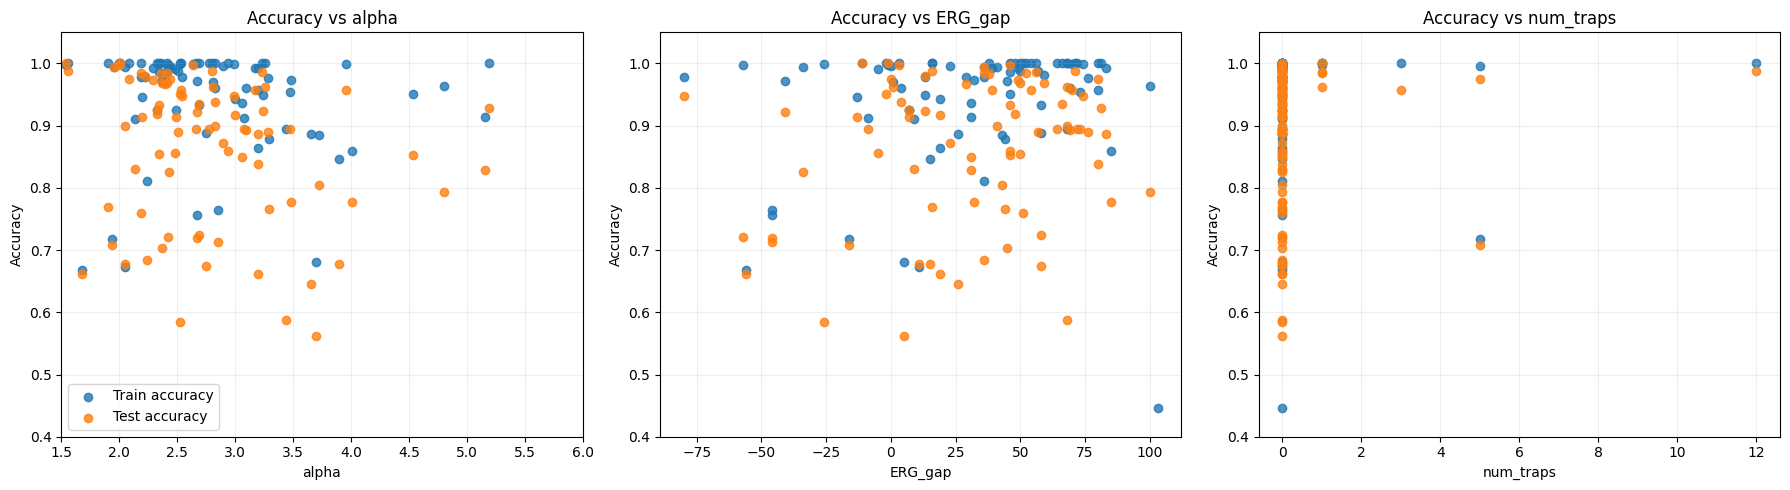

In [14]:
if results_df.empty:
    print("No successful trainings to plot.")
else:
    import matplotlib.pyplot as plt

    plot_df = results_df.sort_values(["source", "dataset_uid"]).copy()

    metrics = ["alpha", "ERG_gap", "num_traps"]
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5), squeeze=False)

    for ax, metric in zip(axes[0], metrics):
        ax.scatter(plot_df[metric], plot_df["train_accuracy"], label="Train accuracy", alpha=0.8)
        ax.scatter(plot_df[metric], plot_df["test_accuracy"], label="Test accuracy", alpha=0.8)
        ax.set_xlabel(metric)
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0.4, 1.05)
        if metric=='alpha':
          ax.set_xlim(1.5,6)
        ax.set_title(f"Accuracy vs {metric}")
        ax.grid(alpha=0.2)

    axes[0, 0].legend()
    fig.tight_layout()
    plt.show()


# Rank Correlations

In [15]:
# Rank correlation between alpha and test_accuracy (Kendall's tau)

import numpy as np
from scipy.stats import kendalltau

if results_df.empty:
    print("No successful trainings to analyze.")
else:
    # Keep only valid numeric pairs
    corr_df = results_df[["alpha", "test_accuracy"]].copy()
    corr_df["alpha"] = np.array(corr_df["alpha"], dtype=float)
    corr_df["test_accuracy"] = np.array(corr_df["test_accuracy"], dtype=float)
    corr_df = corr_df.replace([np.inf, -np.inf], np.nan).dropna()

    if len(corr_df) < 3:
        print(f"Not enough valid points for Kendall tau (n={len(corr_df)}). Need at least 3.")
    else:
        tau, p = kendalltau(corr_df["alpha"], corr_df["test_accuracy"], nan_policy="omit")

        print(f"Kendall's tau(alpha, test_accuracy): {tau:.4f}")
        print(f"p-value: {p:.4g}")
        print(f"n: {len(corr_df)}")

Kendall's tau(alpha, test_accuracy): -0.2115
p-value: 0.004936
n: 82
